In [4]:
import sys

sys.path.append("../berries")


In [1]:
from datasets import load_dataset

mnist = load_dataset("mnist").with_format("jax")
mnistData = mnist['train']
X_img = mnistData['image']
y = mnistData['label']
X_img_test = mnist["test"]["image"]
n_test_samples = X_img_test.shape[0]
X_test = X_img_test.reshape((n_test_samples, -1))
y_test = mnist["test"]["label"]
n_samples, _, _ = X_img.shape
X = X_img.reshape((n_samples, -1))
n_samples, d_x = X.shape
d_y = len(set(y.tolist()))


/home/owner/Projects/picojam/pico/.venv/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mnist
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
X = X / 255.0
X_test = X_test / 255.0

In [5]:
d_h_layer = 128
d_h = 64
n_layers = 1
d_in = d_x
# d_out = d_y
d_out = d_x


In [60]:
import optax
from jax.numpy import mean
from jax import grad, jit
from jax.tree_util import tree_map
from pf import F, _
import nn
import importlib
importlib.reload(nn)
import random_utils
import init_utils
from nn import mglu_net_config, mglu_net, affine, init_weights, fmt_weights

seed = 0
key_gen = random_utils.infinite_safe_keys(seed)

def accuracy(logits, y):
    return (logits.argmax(-1) == y).mean()


mglu_b = F(mglu_net).vmap((0, None, None), 0)


def l2_loss(to_logits, W, x):
    return ((to_logits(x, W) - x) ** 2).mean()

loss_b = F(l2_loss).f(mglu_net,  _, _).vmap(( None, 0), 0)
loss_bm = loss_b >> mean

def l2_loss_noise(to_logits, W, x, noise):
    return ((to_logits(x + noise, W) - x) ** 2).mean()

loss_noise_b = F(l2_loss_noise).f(mglu_net,  _, _, _).vmap(( None, 0, 0), 0)
loss_noise_bm = loss_noise_b >> mean

lr = 0.001
mask_fn = lambda p: tree_map(lambda x: not isinstance(x, int), p)
# opt = optax.multi_transform({"sgd": optax.rmsprop(lr), "zero": optax.set_to_zero()}, mask_fn)
opt = optax.masked(optax.rmsprop(lr), mask_fn)

def get_noise(size, key):
    return init_utils.normal_init(key, sd=0.1, shape=[size, d_x])

# method = {"type": "zer0", "std": 0.001}
method = {"type": "normal", "std": 0.01}
W = init_weights(next(key_gen), mglu_net_config(d_in, d_h_layer, d_out, d_h, n_layers, method))
loss0 = loss_bm(W, X_test)
print(loss0)
print(fmt_weights(W)[0])
state = opt.init(W)

@jit
def update(W, x, noise, opt_state):
    grads = grad(loss_noise_bm)(W, x, noise)
    updates, opt_state = opt.update(grads, opt_state)
    new_W = optax.apply_updates(W, updates)
    return new_W, opt_state

0.11397529
mglu:
    tuple:
        sglu:
            wv:
                array shape: (784, 64)
            wu:
                array shape: (784, 64)
            wo:
                array shape: (64, 128)
            total params: 108544
        rmsn:
            d:
                128.0
            total params: 1
        total params: 108545
    tuple:
        sglu:
            wv:
                array shape: (128, 64)
            wu:
                array shape: (128, 64)
            wo:
                array shape: (64, 784)
            total params: 66560
        rmsn:
            d:
                784.0
            total params: 1
        total params: 66561
    total params: 175106
sglu:
    wv:
        array shape: (784, 64)
    wu:
        array shape: (784, 64)
    wo:
        array shape: (64, 784)
    total params: 150528
total params: 325634



0.022795323 0.01655713


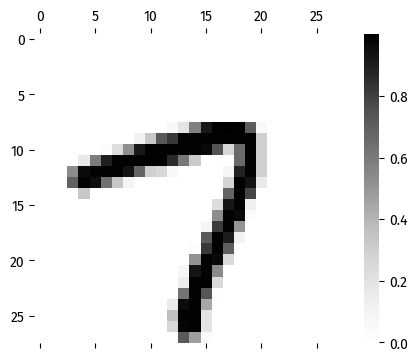

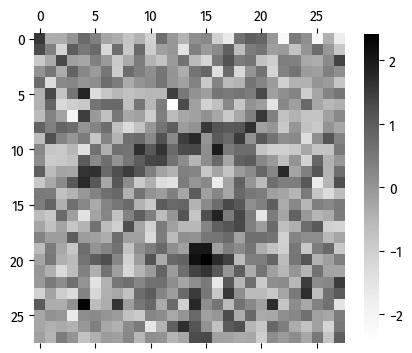

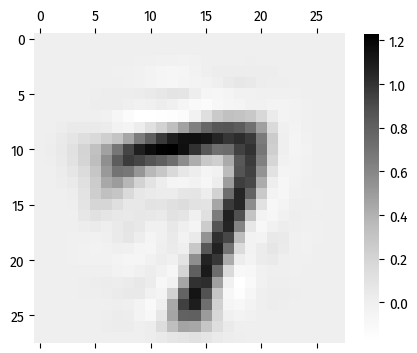

0.02221037 0.015166383
0.022177164 0.017055353
0.022067856 0.016507193
0.02243787 0.016745666
0.021891328 0.015445544


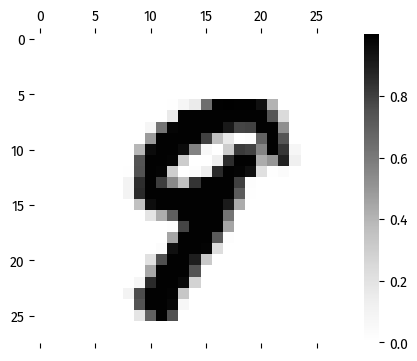

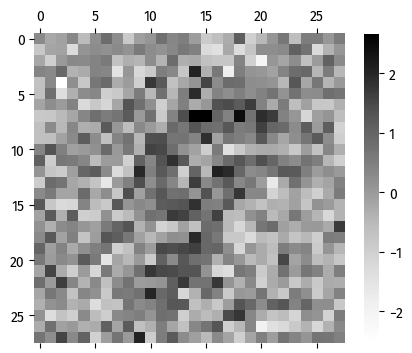

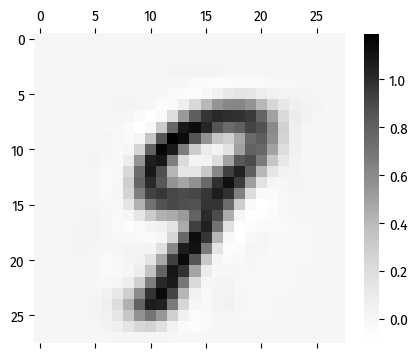

0.02232316 0.01665637
0.022079453 0.015406277
0.022010952 0.015263029
0.02159305 0.01683416
0.02230157 0.016996888


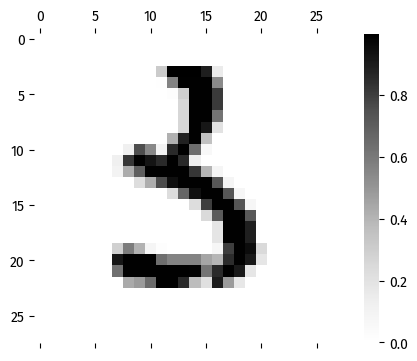

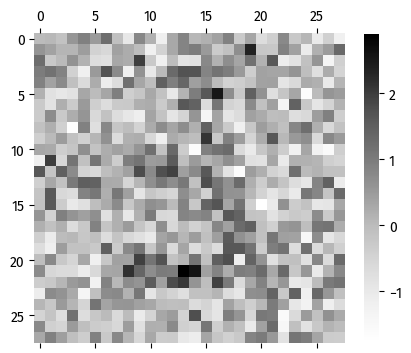

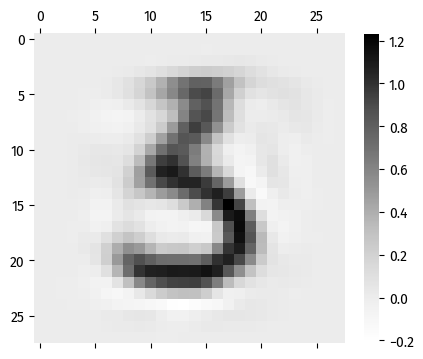

0.021988649 0.016032668
0.021724652 0.015673373
0.021682264 0.016806683
0.021522697 0.015809976
0.021869794 0.015294479


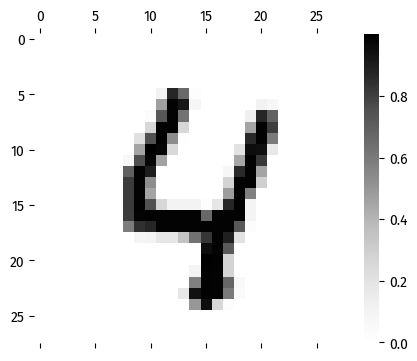

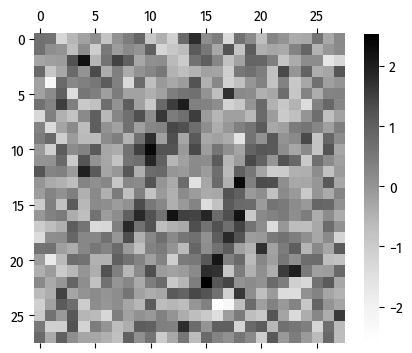

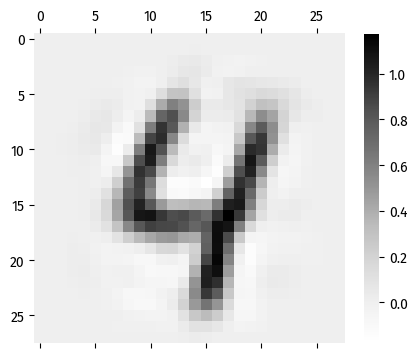

0.021836631 0.015263972
0.022110196 0.01636353
0.022318197 0.015413368
0.021377834 0.015473446
0.021943063 0.01677112


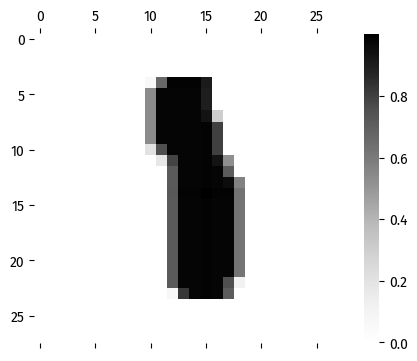

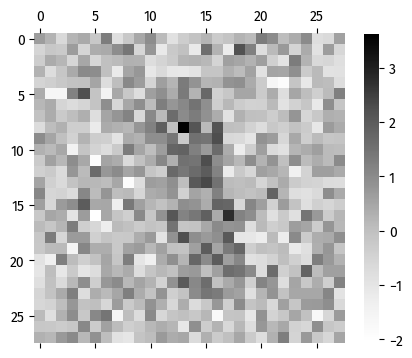

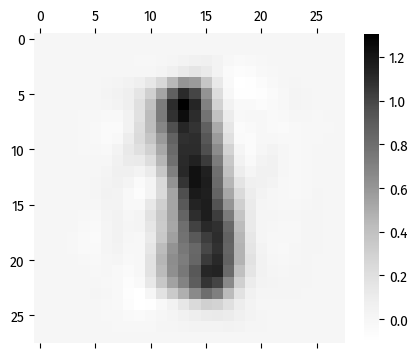

0.022120362 0.0168928
0.021763798 0.015382404
0.022085812 0.015385662
0.022002028 0.016351799


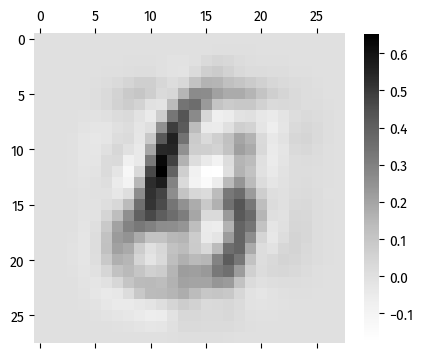

0.0152456295


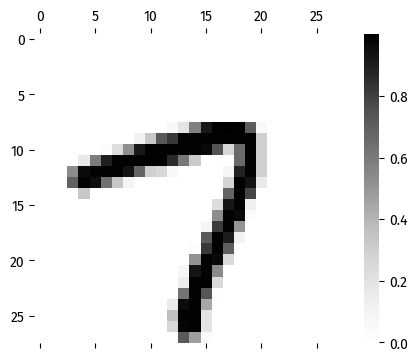

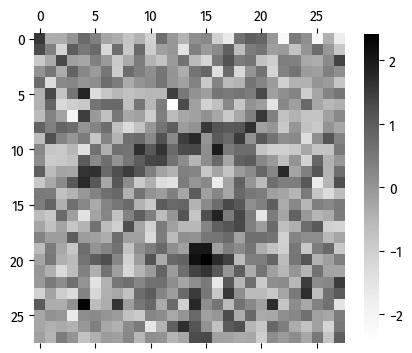

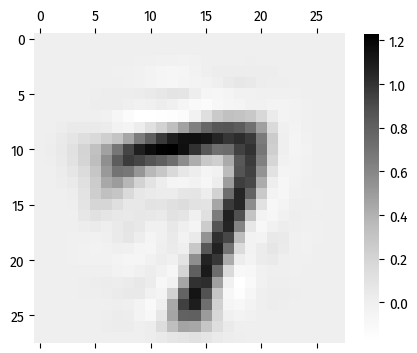

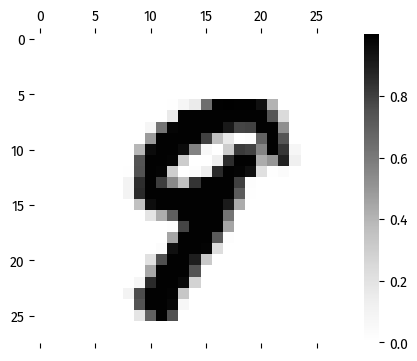

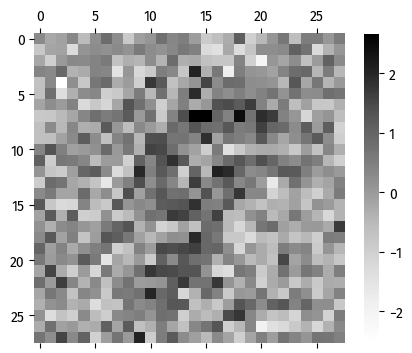

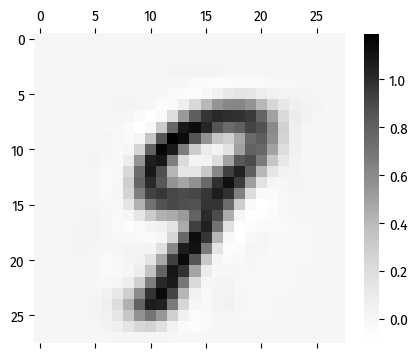

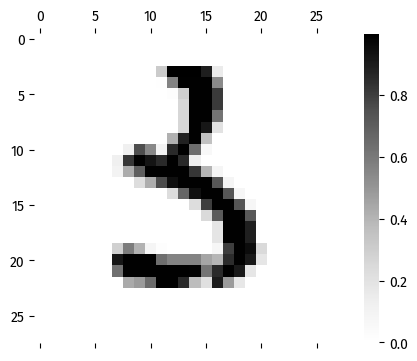

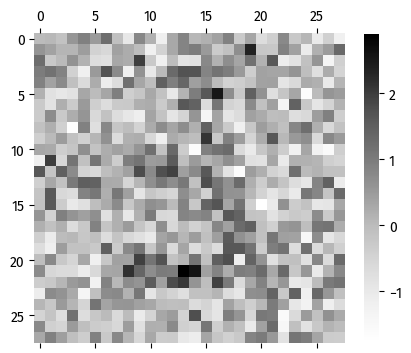

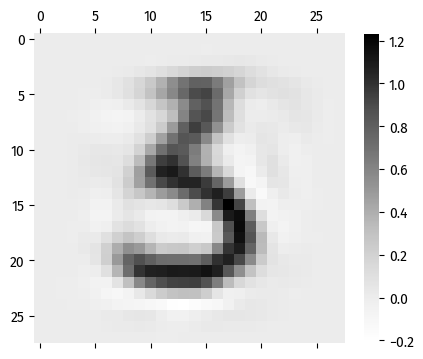

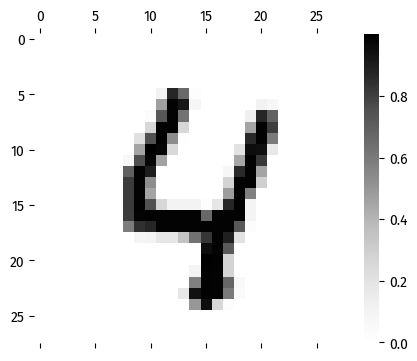

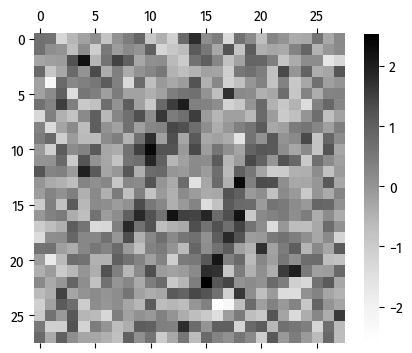

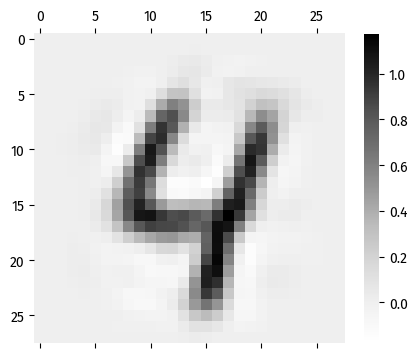

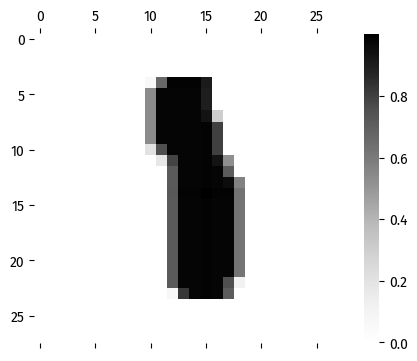

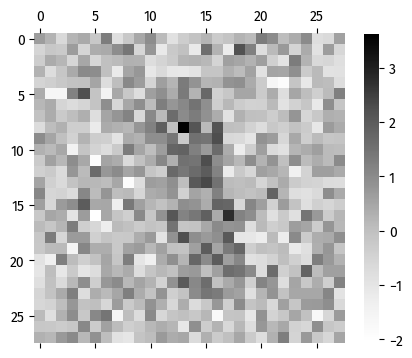

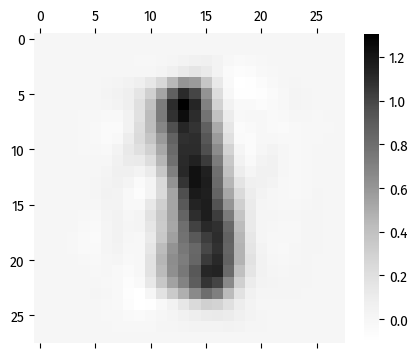

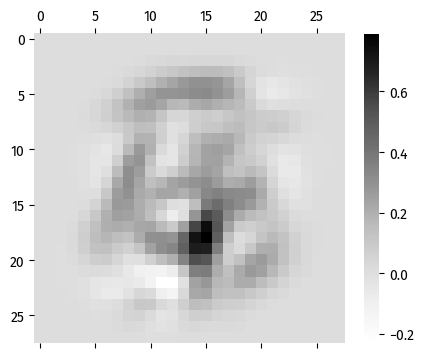

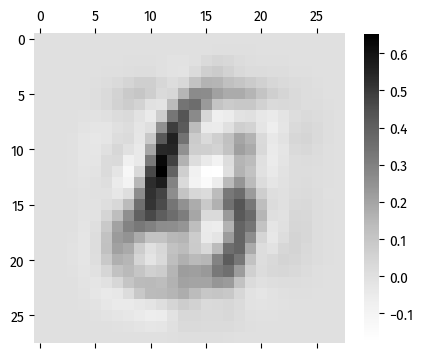

In [65]:
from plot_utils import visualize_matrix
from IPython.display import display
import math, random


loss_dt = loss_b.f(_, X_test)
loss_b_dt = loss_dt >> mean

def get_noise(size, key):
    return init_utils.normal_init(key, sd=0.9, shape=[size, d_x])

batch_size = 1024

def sample():
    return X[random.sample(range(n_samples), batch_size), :]

for i in range(5000):
    key = next(key_gen)
    noise = get_noise(batch_size, key)
    data = sample()
    W, state = update(W, data, noise, state)
    if i % 200 == 0:
        print(loss_noise_bm(W, data, noise), loss_b_dt(W))
    if i % 1000 == 0:
        image_id = math.ceil(random.uniform(0, 1) * n_samples)
        plt, __, __ = visualize_matrix(X[image_id, :].reshape(28, 28), dpi=100)
        display(plt)

        plt, __, __ = visualize_matrix((X[image_id, :] + noise[image_id, :]).reshape(28, 28), dpi=100)
        display(plt)

        plt, __, __ = visualize_matrix(mglu_net(X[image_id, :], W).reshape(28, 28), dpi=100)
        display(plt)

key = next(key_gen)
noise = get_noise(1, key)
plt, __, __ = visualize_matrix(mglu_net(noise, W).reshape(28, 28), dpi=100)
key = next(key_gen)
noise = get_noise(1, key)
plt, __, __ = visualize_matrix(mglu_net(noise, W).reshape(28, 28), dpi=100)
display(plt)
print(loss_b_dt(W))
